In [1]:
from torchvision import datasets, transforms
import torch

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_valset, batch_size=64, shuffle=False)

In [2]:
from torch import nn
from torchvision.models import ResNet50_Weights, resnet50

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)

In [3]:
model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/jenda/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:17<00:00, 5.72MB/s]


In [ ]:
#TRAINING
import time
from tqdm import tqdm

epochs = 10

start_ts = time.time()

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

for epoch in range(epochs):
    total_loss = 0

    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    model.train()
    
    for i, data in progress:
        X, y = data[0], data[1]
        model.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss

        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0], data[1]

            outputs = model(X) # this get's the prediction from the network

            val_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
print(f"Training time: {time.time()-start_ts}s")

In [4]:
#LOADING
PATH = "Model.pth"
save = False
load = True

if save:
    torch.save(model.state_dict(), PATH)

if load:
    model.load_state_dict(torch.load(PATH))

In [5]:
#TESTING
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

Accuracy of the network on the 50000 train images: 98.8 %


In [1]:
#DRAWING
import pygame as pg

def init():
    global screen
 
    pg.init()
    screen = pg.display.set_mode((500, 500))
    mainloop()
 
 
drawing = False
last_pos = None
w = 20
color = (255, 255, 255)
 
 
def draw(event):
    global drawing, last_pos, w
 
    if event.type == pg.MOUSEMOTION:
        if (drawing):
            mouse_position = pg.mouse.get_pos()
            pg.draw.circle(screen, color, mouse_position, w)
    elif event.type == pg.MOUSEBUTTONUP:
        mouse_position = (0, 0)
        drawing = False
        last_pos = None
    elif event.type == pg.MOUSEBUTTONDOWN:
        drawing = True
    elif event.type == pg.KEYDOWN:
        drawing = True
    elif event.type == pg.KEYUP:
        drawing = False
 
 
def mainloop():
    global screen
 
    run = True
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
            if event.type == pg.KEYDOWN:
                if event.key == pg.K_SPACE:
                    pg.image.save(screen, "image.png")
                    run = False
            draw(event)
        pg.display.flip()
    pg.quit()

 
init()

pygame 2.5.2 (SDL 2.28.3, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


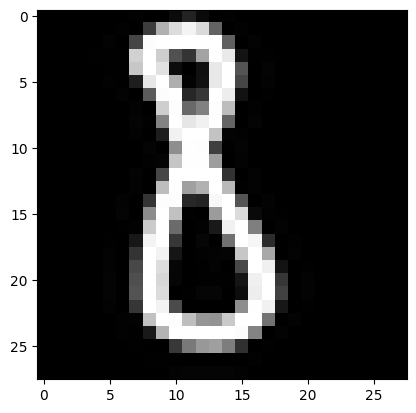

In [2]:
#CONVERTING
import torch
from PIL import Image
from torchvision.transforms import Compose, PILToTensor, Lambda
import matplotlib.pyplot as plt

image = Image.open("image.png").convert("L").resize((28,28),Image.Resampling.LANCZOS)

transform = Compose([
    PILToTensor(),
    Lambda(lambda image: image.view(-1, 1, 28, 28))
])

# Y = (X-A)/(B-A) * (D-C) + C where x=input, ab=range in which is x, cd=range we want x to be
func = lambda x: (x-0)/(255-0) * (1-0) + 0

img_tensor = func(transform(image).to(torch.float))

plt.imshow(img_tensor.view(28, 28).tolist(), cmap='gray')
plt.show()

In [5]:
#PREDICTING
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs.data, 1)
    print(predicted.tolist()[0])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
accuracy = outputs.tolist()[0]
ax.bar(categories,accuracy)
plt.show()

NameError: name 'model' is not defined